In [1]:
import sys
import os
import pandas as pd
import numpy as np
from itertools import product

from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

import warnings
warnings.filterwarnings('once')

In [2]:
def load_datasets():
    current_dir = os.getcwd()
    ROOT_PATH = os.path.dirname(current_dir)
    sys.path.insert(1, ROOT_PATH)
    import root

    train = pd.read_pickle(root.DIR_DATA_STAGE + 'train_preprocessed.pkl')
    test = pd.read_pickle(root.DIR_DATA_STAGE + 'test_preprocessed.pkl')
    return root, train, test

In [3]:
def create_model(data_train, levels, lags, steps, recurrent_units, dense_units, learning_rate):
    model = create_and_compile_model(
        series=data_train,
        levels=levels, 
        lags=lags,
        steps=steps,
        recurrent_layer="LSTM",
        recurrent_units=recurrent_units,
        dense_units=dense_units,
        optimizer=Adam(learning_rate=learning_rate), 
        loss=MeanSquaredError()
    )
    return model

In [4]:
def create_forecaster(data_train, data_val, model, levels, steps, lags, epochs, batch_size):
    forecaster = ForecasterRnn(
        regressor=model,
        levels=levels,
        steps=steps,
        lags=lags,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,             # Número de épocas para entrenar el modelo.
            "batch_size": batch_size,     # Tamaño del batch para entrenar el modelo.
            "series_val": data_val,       # Datos de validación para el entrenamiento del modelo.
        },
    )
    forecaster.fit(data_train)
    return forecaster

In [5]:
def backtesting(data, end_val, forecaster, levels):
    cv = TimeSeriesFold(
        steps=forecaster.max_step,
        initial_train_size=len(data.loc[:end_val, :]),
        refit=False,
    )
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=data,
        levels=forecaster.levels,
        cv=cv,
        metric=root_mean_squared_error,
        verbose=False,
    )
    return metrics, predictions

In [6]:
root, train, test = load_datasets()
data = pd.concat([train, test])
end_val = '2022-08-31 23:59:59'
val = train.loc[end_val:]
train = train.loc[:end_val]

In [7]:
series = ['target', 'temperature', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'euros_per_mwh', 'installed_capacity'] 
levels = ['target']  # Serie que se quiere predecir
steps = 24           # Pasos a futuro a predecir

data_train = train[series].copy()
data_val = val[series].copy()
data_test = test[series].copy()

In [8]:
param_grid = {
    "lags": [24, 72],
    "recurrent_units": [[100, 50], [128, 64]],
    "dense_units": [[32, 16], [64, 32]],
    "learning_rate": [0.01, 0.001],
    "epochs": [4, 8],
    "batch_size": [64, 128],
}

grid = list(product(*param_grid.values()))
best_metrics = float("inf")
best_params = None
best_forecaster = None
best_predictions = None

In [9]:
# metrics

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



Training model 1/64 with params: (24, [100, 50], [32, 16], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0296 - val_loss: 0.0123
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0118 - val_loss: 0.0099
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - val_loss: 0.0121
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0083 - val_loss: 0.0296
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0087 - val_loss: 0.0171
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0083 - val_loss: 0.0187
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0080 - val_loss: 0.0107


  0%|          | 0/273 [00:00<?, ?it/s]

0.159902133334875 <class 'numpy.float64'> inf <class 'float'>
New best model found with RMSE: 0.159902133334875
Training model 2/64 with params: (24, [100, 50], [32, 16], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0292 - val_loss: 0.0135
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0088 - val_loss: 0.0158
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0086 - val_loss: 0.0116
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0077 - val_loss: 0.0119
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0076 - val_loss: 0.0133


  0%|          | 0/273 [00:00<?, ?it/s]

0.1433535554292978 <class 'numpy.float64'> 0.159902133334875 <class 'numpy.float64'>
New best model found with RMSE: 0.1433535554292978
Training model 3/64 with params: (24, [100, 50], [32, 16], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0294 - val_loss: 0.0163
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0086 - val_loss: 0.0122
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 1/8
136/136 ━━━━━━━━━━━━

  0%|          | 0/273 [00:00<?, ?it/s]

0.15311746396392872 <class 'numpy.float64'> 0.1433535554292978 <class 'numpy.float64'>
Training model 4/64 with params: (24, [100, 50], [32, 16], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0324 - val_loss: 0.0110
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0185 - val_loss: 0.0125
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0119 - val_loss: 0.0149
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0084 - val_loss: 0.0147
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0080 - val_loss: 0.0094
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 2/8


  0%|          | 0/273 [00:00<?, ?it/s]

0.14207188133840767 <class 'numpy.float64'> 0.1433535554292978 <class 'numpy.float64'>
New best model found with RMSE: 0.14207188133840767
Training model 5/64 with params: (24, [100, 50], [32, 16], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0315 - val_loss: 0.0095
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0126 - val_loss: 0.0163
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0100 - val_loss: 0.0116
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0082 - val_loss: 0.0129
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0071 - val_loss: 0.0706
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0103 - val_loss: 0.0203
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0061 - val_loss: 0.0428


  0%|          | 0/273 [00:00<?, ?it/s]

0.23667716137888462 <class 'numpy.float64'> 0.14207188133840767 <class 'numpy.float64'>
Training model 6/64 with params: (24, [100, 50], [32, 16], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0366 - val_loss: 0.0107
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0249 - val_loss: 0.0117
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0105 - val_loss: 0.0443
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0092 - val_loss: 0.0378
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0082 - val_loss: 0.0261
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0074 - val_loss: 0.0423


  0%|          | 0/273 [00:00<?, ?it/s]

0.21687437187738012 <class 'numpy.float64'> 0.14207188133840767 <class 'numpy.float64'>
Training model 7/64 with params: (24, [100, 50], [32, 16], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0325 - val_loss: 0.0098
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0173 - val_loss: 0.0122
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0093 - val_loss: 0.0387
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0078 - val_loss: 0.0282
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0070 - val_loss: 0.0474
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0063 - val_loss: 0.0767
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0642
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0050 - val_loss

  0%|          | 0/273 [00:00<?, ?it/s]

0.1871859495698286 <class 'numpy.float64'> 0.14207188133840767 <class 'numpy.float64'>
Training model 8/64 with params: (24, [100, 50], [32, 16], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0355 - val_loss: 0.0112
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0236 - val_loss: 0.0127
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0142 - val_loss: 0.0254
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0115 - val_loss: 0.0262
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0104 - val_loss: 0.0265
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0097 - val_loss: 0.0439
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0085 - val_loss: 0.0310
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0075 - val_loss: 0.0333
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0070 - val_loss: 0.0648
Epoch 2/8

  0%|          | 0/273 [00:00<?, ?it/s]

0.2126029841643272 <class 'numpy.float64'> 0.14207188133840767 <class 'numpy.float64'>
Training model 9/64 with params: (24, [100, 50], [64, 32], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0252 - val_loss: 0.0058
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0139 - val_loss: 0.0105
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0097 - val_loss: 0.0267
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0122 - val_loss: 0.0090
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0080 - val_loss: 0.0107
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0086 - val_loss: 0.0092


  0%|          | 0/273 [00:00<?, ?it/s]

0.12464662489278056 <class 'numpy.float64'> 0.14207188133840767 <class 'numpy.float64'>
New best model found with RMSE: 0.12464662489278056
Training model 10/64 with params: (24, [100, 50], [64, 32], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0304 - val_loss: 0.0144
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0120 - val_loss: 0.0141
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0093 - val_loss: 0.0152
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0081 - val_loss: 0.0114
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0080 - val_loss: 0.0095
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0073 - val_loss: 0.0095
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0069 - val_loss: 0.0093


  0%|          | 0/273 [00:00<?, ?it/s]

0.1531519920536428 <class 'numpy.float64'> 0.12464662489278056 <class 'numpy.float64'>
Training model 11/64 with params: (24, [100, 50], [64, 32], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0250 - val_loss: 0.0083
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0100 - val_loss: 0.0082
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0112 - val_loss: 0.0156
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0082 - val_loss: 0.0094
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0086 - val_loss: 0.0166
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0071 - val_loss:

  0%|          | 0/273 [00:00<?, ?it/s]

0.15402559070277255 <class 'numpy.float64'> 0.12464662489278056 <class 'numpy.float64'>
Training model 12/64 with params: (24, [100, 50], [64, 32], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0283 - val_loss: 0.0078
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0106 - val_loss: 0.0078
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0097 - val_loss: 0.0061
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0088 - val_loss: 0.0131
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0086 - val_loss: 0.0137
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0077 - val_loss: 0.0093
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 2/

  0%|          | 0/273 [00:00<?, ?it/s]

0.12418370723247883 <class 'numpy.float64'> 0.12464662489278056 <class 'numpy.float64'>
New best model found with RMSE: 0.12418370723247883
Training model 13/64 with params: (24, [100, 50], [64, 32], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0279 - val_loss: 0.0067
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0103 - val_loss: 0.0156
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0093 - val_loss: 0.0292
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0077 - val_loss: 0.0115
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0072 - val_loss: 0.0266
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078 - val_loss: 0.0534
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0065 - val_loss: 0.0304


  0%|          | 0/273 [00:00<?, ?it/s]

0.1732831284217041 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 14/64 with params: (24, [100, 50], [64, 32], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0321 - val_loss: 0.0109
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0157 - val_loss: 0.0190
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0101 - val_loss: 0.0539
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0093 - val_loss: 0.0361
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0084 - val_loss: 0.0304
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0082 - val_loss: 0.0311
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0076 - val_loss: 0.0311
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0073 - val_loss: 0.0734


  0%|          | 0/273 [00:00<?, ?it/s]

0.2362410796675502 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 15/64 with params: (24, [100, 50], [64, 32], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0282 - val_loss: 0.0072
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0108 - val_loss: 0.0059
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0150 - val_loss: 0.0297
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0086 - val_loss: 0.0492
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0083 - val_loss: 0.1294
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0076 - val_loss: 0.0548
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0074 - val_loss: 0.1518
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0071 - val_loss: 0.4430
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0063 - val_loss

  0%|          | 0/273 [00:00<?, ?it/s]

0.2520074183034324 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 16/64 with params: (24, [100, 50], [64, 32], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0322 - val_loss: 0.0167
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0194 - val_loss: 0.0112
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0111 - val_loss: 0.0077
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0083 - val_loss: 0.0113
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0075 - val_loss: 0.0222
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0072 - val_loss: 0.0328
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0066 - val_loss: 0.0257
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0064 - val_loss: 0.0390
Epoch 2/

  0%|          | 0/273 [00:00<?, ?it/s]

0.17341174154463407 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 17/64 with params: (24, [128, 64], [32, 16], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0279 - val_loss: 0.0176
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0126 - val_loss: 0.0132
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0092 - val_loss: 0.0227
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0082 - val_loss: 0.0151
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0081 - val_loss: 0.0147
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0097 - val_loss: 0.0175


  0%|          | 0/273 [00:00<?, ?it/s]

0.15609099134072243 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 18/64 with params: (24, [128, 64], [32, 16], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0338 - val_loss: 0.0084
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0147 - val_loss: 0.0076
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0095 - val_loss: 0.0175
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0090 - val_loss: 0.0133
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0085 - val_loss: 0.0124
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0078 - val_loss: 0.0116


  0%|          | 0/273 [00:00<?, ?it/s]

0.14522709732710018 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
Training model 19/64 with params: (24, [128, 64], [32, 16], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0320 - val_loss: 0.0108
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0267 - val_loss: 0.0119
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0224 - val_loss: 0.0128
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0188 - val_loss: 0.0088
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0137 - val_loss: 0.0162
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0112 - val_loss: 0.0196
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0107 - val_loss

  0%|          | 0/273 [00:00<?, ?it/s]

0.12181725472244834 <class 'numpy.float64'> 0.12418370723247883 <class 'numpy.float64'>
New best model found with RMSE: 0.12181725472244834
Training model 20/64 with params: (24, [128, 64], [32, 16], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0308 - val_loss: 0.0080
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0088 - val_loss: 0.0179
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0082 - val_loss: 0.0127
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0080 - val_loss: 0.0138
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0080 - val_loss: 0.0149
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0071 - val_loss: 0.0132
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 

  0%|          | 0/273 [00:00<?, ?it/s]

0.16622743435041373 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 21/64 with params: (24, [128, 64], [32, 16], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0323 - val_loss: 0.0085
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0181 - val_loss: 0.0155
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0084 - val_loss: 0.0165
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0074 - val_loss: 0.0205
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0065 - val_loss: 0.0157


  0%|          | 0/273 [00:00<?, ?it/s]

0.13602699552798997 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 22/64 with params: (24, [128, 64], [32, 16], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0354 - val_loss: 0.0108
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0247 - val_loss: 0.0089
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0114 - val_loss: 0.0193
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0094 - val_loss: 0.0210
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0090 - val_loss: 0.0210
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0075 - val_loss: 0.0316
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0068 - val_loss: 0.0357


  0%|          | 0/273 [00:00<?, ?it/s]

0.21402635121902003 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 23/64 with params: (24, [128, 64], [32, 16], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0320 - val_loss: 0.0103
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0152 - val_loss: 0.0089
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0112 - val_loss: 0.0160
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0093 - val_loss: 0.0147
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0095 - val_loss: 0.0350
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0067 - val_loss: 0.0367
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0061 - val_loss: 0.0284
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0057 - val_los

  0%|          | 0/273 [00:00<?, ?it/s]

0.16087374554092806 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 24/64 with params: (24, [128, 64], [32, 16], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0346 - val_loss: 0.0098
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0190 - val_loss: 0.0094
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0115 - val_loss: 0.0172
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0100 - val_loss: 0.0194
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0080 - val_loss: 0.0409
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0079 - val_loss: 0.0314
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0066 - val_loss: 0.0340
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0061 - val_loss: 0.0359
Epoch 2

  0%|          | 0/273 [00:00<?, ?it/s]

0.24141332549174893 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 25/64 with params: (24, [128, 64], [64, 32], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0262 - val_loss: 0.0276
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0098 - val_loss: 0.0229
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0094 - val_loss: 0.0200
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0083 - val_loss: 0.0113
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0077 - val_loss: 0.0128


  0%|          | 0/273 [00:00<?, ?it/s]

0.1319057796333497 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 26/64 with params: (24, [128, 64], [64, 32], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0285 - val_loss: 0.0170
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0068 - val_loss: 0.0122


  0%|          | 0/273 [00:00<?, ?it/s]

0.13881890053400592 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 27/64 with params: (24, [128, 64], [64, 32], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0243 - val_loss: 0.0093
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0087 - val_loss: 0.0117
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0096 - val_loss

  0%|          | 0/273 [00:00<?, ?it/s]

0.16080888845950542 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 28/64 with params: (24, [128, 64], [64, 32], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0306 - val_loss: 0.0166
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0096 - val_loss: 0.0174
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0087 - val_loss: 0.0216
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0082 - val_loss: 0.0141
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0075 - val_loss: 0.0188
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0075 - val_loss: 0.0106
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0063 - val_loss: 0.0195
Epoch 2/

  0%|          | 0/273 [00:00<?, ?it/s]

0.18910667320433008 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 29/64 with params: (24, [128, 64], [64, 32], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0297 - val_loss: 0.0057
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0112 - val_loss: 0.0153
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0091 - val_loss: 0.0129
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0084 - val_loss: 0.0159
Epoch 1/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0073 - val_loss: 0.0443
Epoch 2/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0065 - val_loss: 0.0247
Epoch 3/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0056 - val_loss: 0.0431
Epoch 4/4
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0048 - val_loss: 0.0334


  0%|          | 0/273 [00:00<?, ?it/s]

0.18758065046363978 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 30/64 with params: (24, [128, 64], [64, 32], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0345 - val_loss: 0.0168
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0187 - val_loss: 0.0137
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0105 - val_loss: 0.0128
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0092 - val_loss: 0.0154
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0083 - val_loss: 0.0428
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0080 - val_loss: 0.0221
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0069 - val_loss: 0.0242
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0069 - val_loss: 0.0378


  0%|          | 0/273 [00:00<?, ?it/s]

0.21475055201145088 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 31/64 with params: (24, [128, 64], [64, 32], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0295 - val_loss: 0.0131
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0119 - val_loss: 0.0065
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0100 - val_loss: 0.0132
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0087 - val_loss: 0.0226
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0080 - val_loss: 0.0254
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0069 - val_loss: 0.0387
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0064 - val_loss: 0.0402
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0054 - val_loss: 0.0409
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0047 - val_los

  0%|          | 0/273 [00:00<?, ?it/s]

0.19457425973897752 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 32/64 with params: (24, [128, 64], [64, 32], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0313 - val_loss: 0.0112
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0149 - val_loss: 0.0093
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0102 - val_loss: 0.0191
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0094 - val_loss: 0.0154
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0085 - val_loss: 0.0316
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0083 - val_loss: 0.0186
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0080 - val_loss: 0.0319
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0074 - val_loss: 0.0284
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0070 - val_loss: 0.0276
Epoch 2

  0%|          | 0/273 [00:00<?, ?it/s]

0.20266921154015655 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 33/64 with params: (72, [100, 50], [32, 16], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 32.6731 - val_loss: 0.0147
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0182 - val_loss: 0.0109
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0156 - val_loss: 0.0105
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0145 - val_loss: 0.0085
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0107 - val_loss: 0.0118


  0%|          | 0/273 [00:00<?, ?it/s]

0.13445767217574614 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 34/64 with params: (72, [100, 50], [32, 16], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0340 - val_loss: 0.0098
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0135 - val_loss: 0.0091
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0100 - val_loss: 0.0090
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0082 - val_loss: 0.0073


  0%|          | 0/273 [00:00<?, ?it/s]

0.13445423001529078 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 35/64 with params: (72, [100, 50], [32, 16], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 114873608.0000 - val_loss: 0.0407
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 3.3206 - val_loss: 0.0429
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0782 - val_loss: 0.0428
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0775 - val_loss: 0.0428
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0764 - val_loss: 0.0427
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0776 - val_loss: 0.0426
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0767 - val_loss: 0.0425
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0759 - val_loss: 0.0424
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0764 - 

  0%|          | 0/273 [00:00<?, ?it/s]

0.2798535645218537 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 36/64 with params: (72, [100, 50], [32, 16], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 2.1093 - val_loss: 0.0137
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.2205 - val_loss: 0.0139
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0337 - val_loss: 0.0137
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0325 - val_loss: 0.0142
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0323 - val_loss: 0.0139
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0326 - val_loss: 0.0143
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0334 - val_loss: 0.0139
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0327 - val_loss: 0.0139
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0325 - val_loss: 0.0139
Epoch 2/8

  0%|          | 0/273 [00:00<?, ?it/s]

0.21639339430888613 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 37/64 with params: (72, [100, 50], [32, 16], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0315 - val_loss: 0.0093
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0143 - val_loss: 0.0080
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0086 - val_loss: 0.0159
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0075 - val_loss: 0.0127
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 28447390.0000 - val_loss: 0.0225
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 5.2603 - val_loss: 0.0161
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0387 - val_loss: 0.0184


  0%|          | 0/273 [00:00<?, ?it/s]

1.0328009263934939 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 38/64 with params: (72, [100, 50], [32, 16], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0349 - val_loss: 0.0086
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0193 - val_loss: 0.0084
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.4742 - val_loss: 0.0075
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0099 - val_loss: 0.0144


  0%|          | 0/273 [00:00<?, ?it/s]

0.15913486450904452 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 39/64 with params: (72, [100, 50], [32, 16], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0330 - val_loss: 0.0103
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0142 - val_loss: 0.0096
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0096 - val_loss: 328.9435
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0087 - val_loss: 0.0115
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0078 - val_loss: 0.0138
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0067 - val_loss: 0.0239
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0061 - val_l

  0%|          | 0/273 [00:00<?, ?it/s]

50.31337504867478 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 40/64 with params: (72, [100, 50], [32, 16], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0333 - val_loss: 0.0084
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0206 - val_loss: 0.0079
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0107 - val_loss: 0.0061
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0087 - val_loss: 28.0300
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0077 - val_loss: 0.0203
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0070 - val_loss: 0.0188
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0058 - val_loss: 0.0151
Epoch 2/

  0%|          | 0/273 [00:00<?, ?it/s]

60.188015444998925 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 41/64 with params: (72, [100, 50], [64, 32], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0256 - val_loss: 0.0065
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0100 - val_loss: 0.0107
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0091 - val_loss: 0.0132
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0087 - val_loss: 0.0169
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0080 - val_loss: 0.0271
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0074 - val_loss: 0.0211
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0063 - val_loss: 0.0146
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0058 - val_loss: 0.0163


  0%|          | 0/273 [00:00<?, ?it/s]

0.15545308754258053 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 42/64 with params: (72, [100, 50], [64, 32], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0285 - val_loss: 0.0149
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0111 - val_loss: 0.0148
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0093 - val_loss: 0.0204
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0088 - val_loss: 0.0194
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0072 - val_loss: 0.0233
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0069 - val_loss: 0.0155
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0060 - val_loss: 0.0219
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0048 - val_loss: 0.0142


  0%|          | 0/273 [00:00<?, ?it/s]

0.13695384803674712 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 43/64 with params: (72, [100, 50], [64, 32], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0314 - val_loss: 0.0071
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0113 - val_loss: 0.0126
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0091 - val_loss: 0.0142
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0093 - val_loss: 0.0142
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0089 - val_loss: 0.0317
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0088 - val_loss: 0.0166
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0081 - val_loss: 0.0226
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0080 - val_loss

  0%|          | 0/273 [00:00<?, ?it/s]

0.19093586874471702 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 44/64 with params: (72, [100, 50], [64, 32], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0320 - val_loss: 0.0098
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0183 - val_loss: 0.0114
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0110 - val_loss: 0.0126
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0080 - val_loss: 0.0180
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0074 - val_loss: 0.0140
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0072 - val_loss: 0.0206
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0070 - val_loss: 0.0129
Epoch 

  0%|          | 0/273 [00:00<?, ?it/s]

0.21218819202658343 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 45/64 with params: (72, [100, 50], [64, 32], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0326 - val_loss: 0.0108
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0129 - val_loss: 0.0103
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0094 - val_loss: 6652.3984
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0083 - val_loss: 0.0135
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0078 - val_loss: 4167915.2500
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0068 - val_loss: 7280931.5000


  0%|          | 0/273 [00:00<?, ?it/s]

199.43411206198903 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 46/64 with params: (72, [100, 50], [64, 32], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0336 - val_loss: 0.0077
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0097 - val_loss: 0.0160
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0084 - val_loss: 0.0107
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0071 - val_loss: 14.2814
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0070 - val_loss: 17311.5410
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0053 - val_loss: 1591247.6250
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0047 - val_loss: 13709635.0000


  0%|          | 0/273 [00:00<?, ?it/s]

1195.3533217332738 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 47/64 with params: (72, [100, 50], [64, 32], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0297 - val_loss: 0.0111
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0094 - val_loss: 0.0119
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0073 - val_loss: 0.5505
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0064 - val_loss: 4251701504.0000
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0053 - val_loss: 35638.6172
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0039 - val_loss: 1822.4159
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0034 - val_loss: 148.1371
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss:

  0%|          | 0/273 [00:00<?, ?it/s]

183.7386339427633 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 48/64 with params: (72, [100, 50], [64, 32], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0337 - val_loss: 0.0087
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0169 - val_loss: 0.0099
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0109 - val_loss: 0.0060
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0090 - val_loss: 0.0280
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.2225 - val_loss: 0.0105
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0141 - val_loss: 0.0111
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0088 - val_loss: 0.0108
Epoch 2/8

  0%|          | 0/273 [00:00<?, ?it/s]

10.597196063554648 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 49/64 with params: (72, [128, 64], [32, 16], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0264 - val_loss: 0.0110
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0099 - val_loss: 0.0224
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0096 - val_loss: 0.0275
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0087 - val_loss: 0.0150
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0083 - val_loss: 0.0201
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0072 - val_loss: 0.0110
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0071 - val_loss: 0.0102


  0%|          | 0/273 [00:00<?, ?it/s]

0.13109934345046403 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 50/64 with params: (72, [128, 64], [32, 16], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0314 - val_loss: 0.0103
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0177 - val_loss: 0.0122
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.0092 - val_loss: 0.0132
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0083 - val_loss: 0.0118
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0079 - val_loss: 0.0192


  0%|          | 0/273 [00:00<?, ?it/s]

0.1972395028042823 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 51/64 with params: (72, [128, 64], [32, 16], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0294 - val_loss: 0.0066
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0122 - val_loss: 0.0095
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0098 - val_loss: 0.0220
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0088 - val_loss: 0.0119
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0083 - val_loss: 0.0155
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0069 - val_loss: 0.0097
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0063 - val_los

  0%|          | 0/273 [00:00<?, ?it/s]

0.14586050121690444 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 52/64 with params: (72, [128, 64], [32, 16], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 674976.0000 - val_loss: 0.0153
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0367 - val_loss: 0.0155
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0364 - val_loss: 0.0155
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0367 - val_loss: 0.0154
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0371 - val_loss: 0.0154
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0361 - val_loss: 0.0154
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0367 - val_loss: 0.0153
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0366 - val_loss: 0.0153
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 0.0361 - val_loss: 0

  0%|          | 0/273 [00:00<?, ?it/s]

0.21860548906898694 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 53/64 with params: (72, [128, 64], [32, 16], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.0323 - val_loss: 0.0113
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0157 - val_loss: 0.0087
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0105 - val_loss: 0.0217
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0087 - val_loss: 0.0204
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0064 - val_loss: 0.0192
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0044 - val_loss: 0.0205
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0033 - val_loss: 0.0358
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0024 - val_loss: 0.8015


  0%|          | 0/273 [00:00<?, ?it/s]

2.5525585086111207 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 54/64 with params: (72, [128, 64], [32, 16], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0354 - val_loss: 0.0089
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0177 - val_loss: 0.0068
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0090 - val_loss: 17035.1738
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0079 - val_loss: 869857.6250
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0289 - val_loss: 0.4761
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0143 - val_loss: 18.9795


  0%|          | 0/273 [00:00<?, ?it/s]

4456.064415131746 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 55/64 with params: (72, [128, 64], [32, 16], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 0.0309 - val_loss: 0.0161
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0142 - val_loss: 0.0171
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0068 - val_loss: 31.1201
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0058 - val_loss: 0.0264
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0045 - val_loss: 0.0316
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0033 - val_loss: 43421528.0000
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0

  0%|          | 0/273 [00:00<?, ?it/s]

16100.46152688337 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 56/64 with params: (72, [128, 64], [32, 16], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0355 - val_loss: 0.0113
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.0231 - val_loss: 0.0105
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0086 - val_loss: 0.0113
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0076 - val_loss: 0.0156
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0061 - val_loss: 0.0199
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0058 - val_loss: 801.1532
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0047 - val_loss: 3.63

  0%|          | 0/273 [00:00<?, ?it/s]

17.749408513260228 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 57/64 with params: (72, [128, 64], [64, 32], 0.01, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0268 - val_loss: 0.0118
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0104 - val_loss: 0.0176
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0093 - val_loss: 0.0126
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0075 - val_loss: 0.0153
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0070 - val_loss: 0.0114
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0060 - val_loss: 0.0092


  0%|          | 0/273 [00:00<?, ?it/s]

0.1273522139121897 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
Training model 58/64 with params: (72, [128, 64], [64, 32], 0.01, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0356 - val_loss: 0.0112
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0155 - val_loss: 0.0083
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0097 - val_loss: 0.0068
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0083 - val_loss: 0.0136
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0085 - val_loss: 0.0074


  0%|          | 0/273 [00:00<?, ?it/s]

0.12118592810398443 <class 'numpy.float64'> 0.12181725472244834 <class 'numpy.float64'>
New best model found with RMSE: 0.12118592810398443
Training model 59/64 with params: (72, [128, 64], [64, 32], 0.01, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0322 - val_loss: 0.0079
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0115 - val_loss: 0.0159
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0090 - val_loss: 0.0167
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0086 - val_loss: 0.0137
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0084 - val_loss: 0.0110
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0083 - val_loss: 0.0104
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 1/8
135/135 ━━━━━━

  0%|          | 0/273 [00:00<?, ?it/s]

0.11941646069599031 <class 'numpy.float64'> 0.12118592810398443 <class 'numpy.float64'>
New best model found with RMSE: 0.11941646069599031
Training model 60/64 with params: (72, [128, 64], [64, 32], 0.01, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0290 - val_loss: 0.0078
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.0108 - val_loss: 0.0206
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0102 - val_loss: 0.0133
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0093 - val_loss: 0.0151
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0085 - val_loss: 0.0149
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.0078 - val_loss: 0.0186
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0073 - val_loss: 0.0223
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━

  0%|          | 0/273 [00:00<?, ?it/s]

0.14081267126466063 <class 'numpy.float64'> 0.11941646069599031 <class 'numpy.float64'>
Training model 61/64 with params: (72, [128, 64], [64, 32], 0.001, 4, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0293 - val_loss: 0.0090
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0081 - val_loss: 0.0191
Epoch 1/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0073 - val_loss: 0.0192
Epoch 2/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0061 - val_loss: 0.0125
Epoch 3/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0104 - val_loss: 0.0121
Epoch 4/4
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0079 - val_loss: 0.0224


  0%|          | 0/273 [00:00<?, ?it/s]

12.76204900535635 <class 'numpy.float64'> 0.11941646069599031 <class 'numpy.float64'>
Training model 62/64 with params: (72, [128, 64], [64, 32], 0.001, 4, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0336 - val_loss: 0.0074
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0152 - val_loss: 0.0100
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0093 - val_loss: 0.0109
Epoch 1/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 2/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0081 - val_loss: 0.0163
Epoch 3/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0076 - val_loss: 0.0182
Epoch 4/4
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0065 - val_loss: 0.0193


  0%|          | 0/273 [00:00<?, ?it/s]

0.706442340053778 <class 'numpy.float64'> 0.11941646069599031 <class 'numpy.float64'>
Training model 63/64 with params: (72, [128, 64], [64, 32], 0.001, 8, 64)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.0288 - val_loss: 0.0071
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0092 - val_loss: 0.0197
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0253 - val_loss: 0.0095
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0120 - val_loss: 0.0169
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0077 - val_loss: 0.0119
Epoch 7/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0069 - val_loss: 0.0109
Epoch 8/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0068 - val_loss: 0.0160
Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0062 - 

  0%|          | 0/273 [00:00<?, ?it/s]

59.09202033372598 <class 'numpy.float64'> 0.11941646069599031 <class 'numpy.float64'>
Training model 64/64 with params: (72, [128, 64], [64, 32], 0.001, 8, 128)
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0306 - val_loss: 0.0079
Epoch 2/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 3/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 4/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0090 - val_loss: 0.0239
Epoch 5/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0086 - val_loss: 0.0219
Epoch 6/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.0072 - val_loss: 11558027.0000
Epoch 7/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 0.0064 - val_loss: 179948992.0000
Epoch 8/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 0.0060 - val_loss: 1363256064.0000
Epoch 1/8
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 

  0%|          | 0/273 [00:00<?, ?it/s]

2810.248755715849 <class 'numpy.float64'> 0.11941646069599031 <class 'numpy.float64'>

Best hyperparameters: (72, [128, 64], [64, 32], 0.01, 8, 64)
Best validation RMSE: 0.11941646069599031


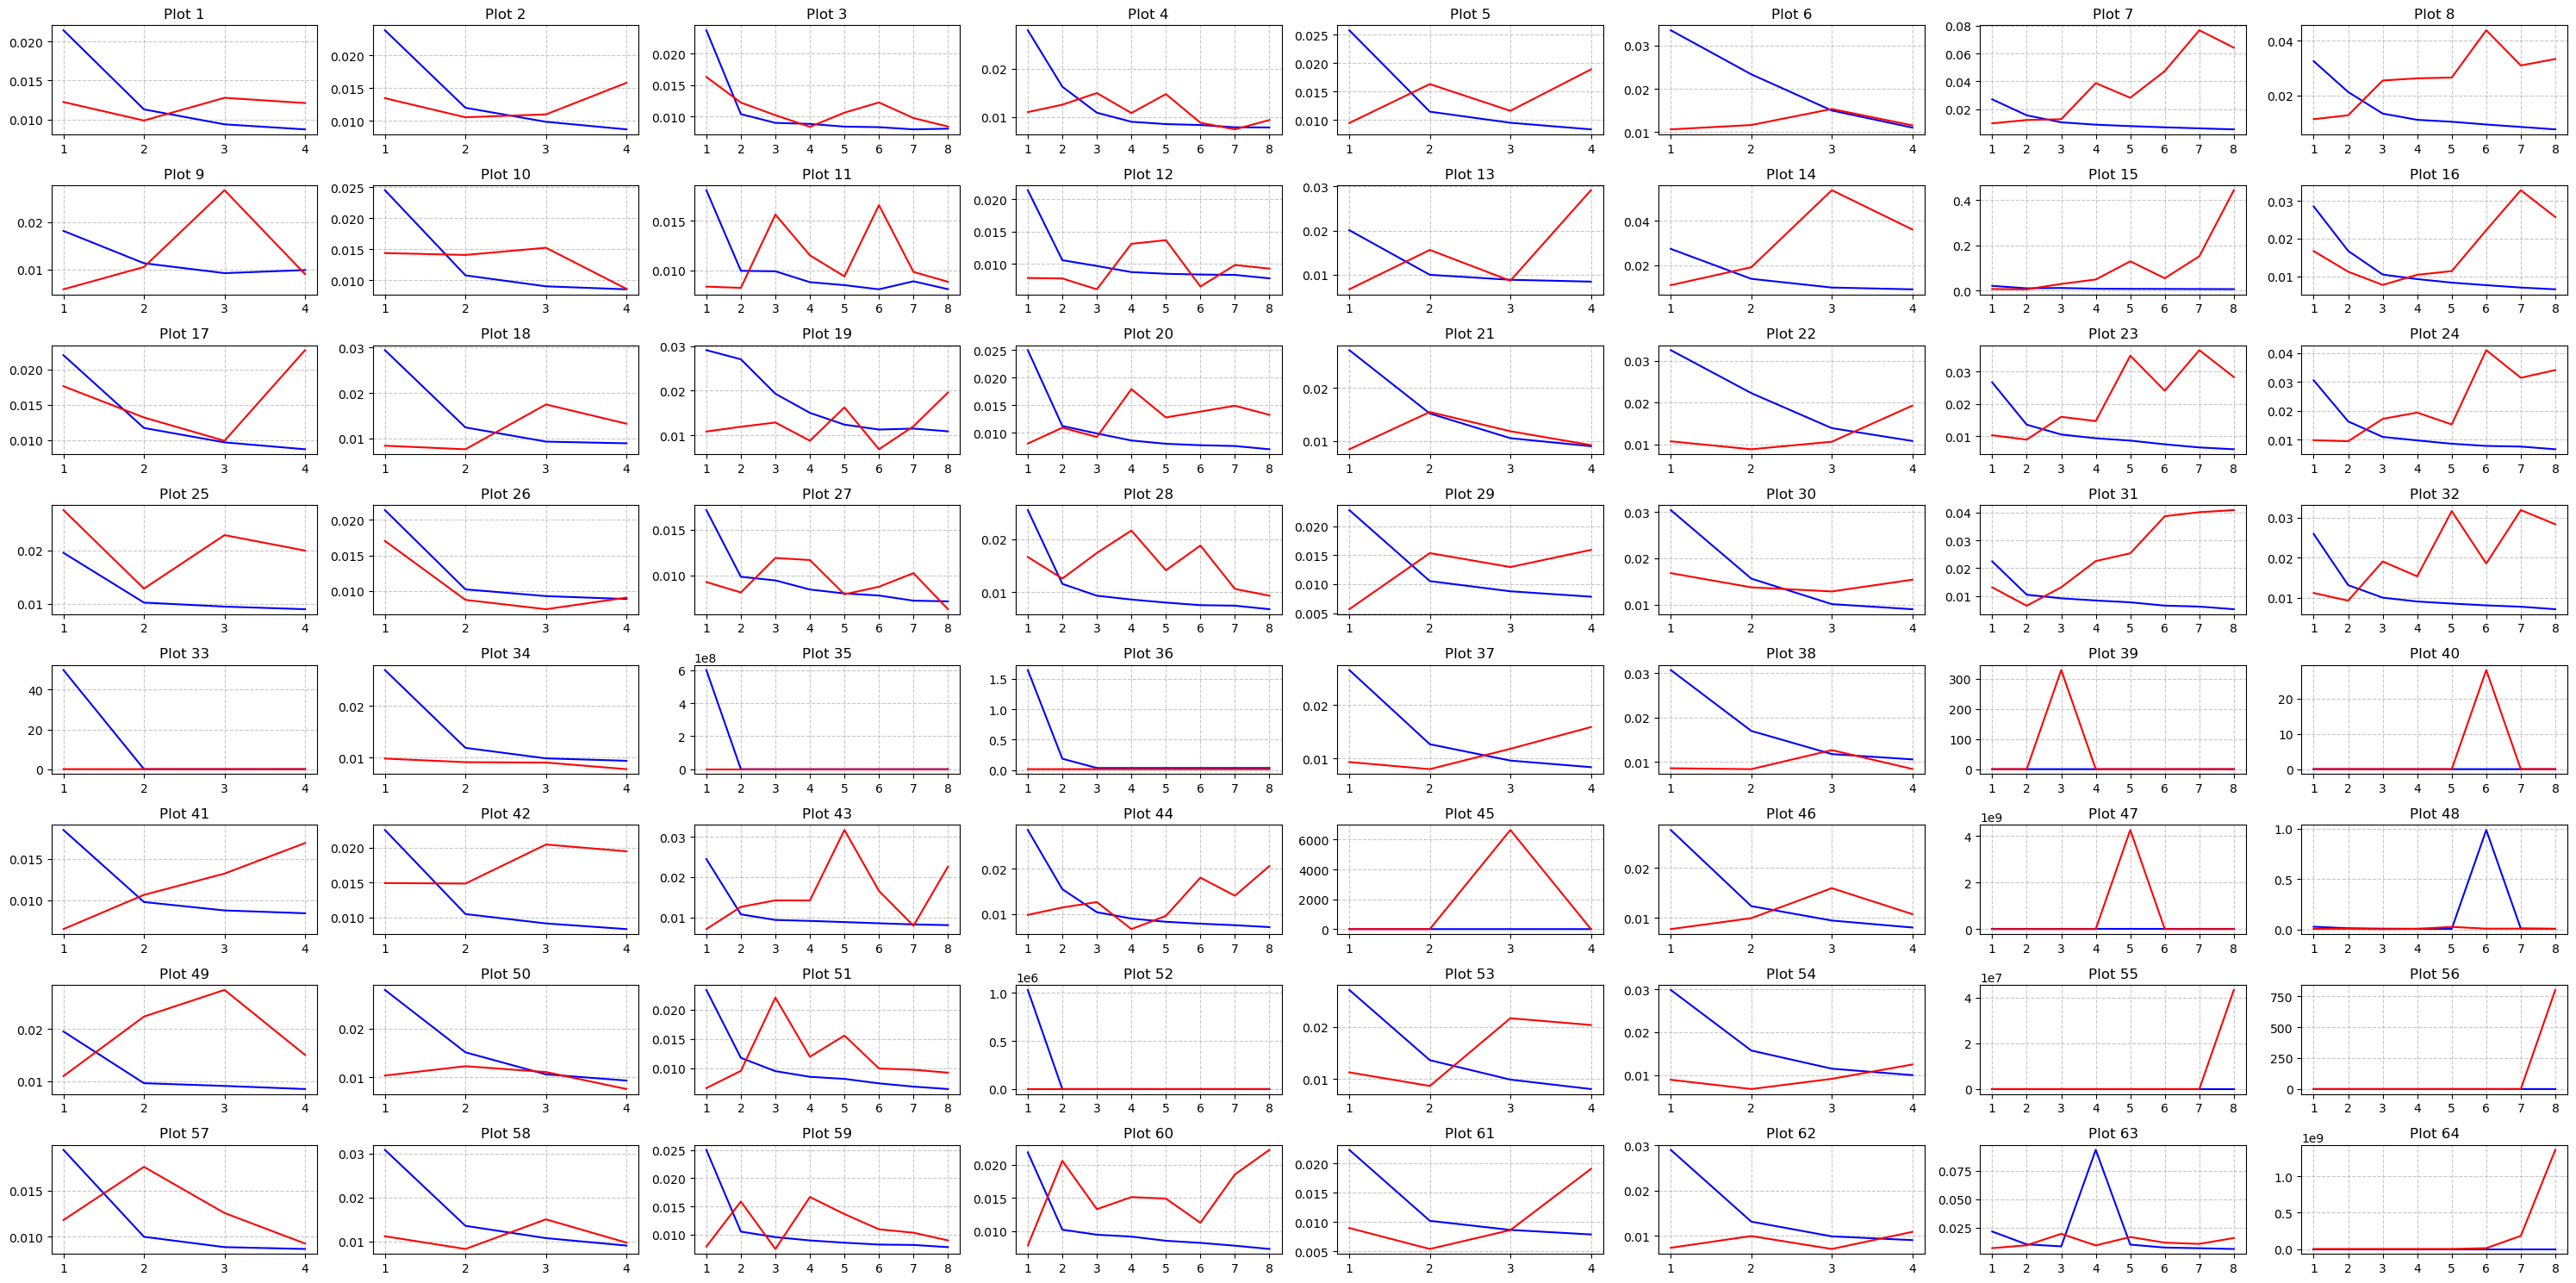

In [10]:
# Save results
fig, ax = plt.subplots(8, 8, figsize=(30, 15))
ax = ax.flatten()
results = pd.DataFrame({'model': [], 'lags': [], 'recurrent_units': [], 'dense_units': [], 'learning_rate': [], 'epochs': [], 'batch_size': [], 'RMSE': []})

for i, params in enumerate(grid):
    print(f"Training model {i + 1}/{len(grid)} with params: {params}")
    lags, recurrent_units, dense_units, learning_rate, epochs, batch_size = params

    # Create the model
    model = create_model(data_train, levels, lags, steps, recurrent_units, dense_units, learning_rate)

    # Create the forecaster
    forecaster = create_forecaster(data_train, data_val, model, levels, steps, lags, epochs, batch_size)

    # Evaluate performance using backtesting
    metrics, predictions = backtesting(data, end_val, forecaster, levels)

    # Check if this combination is the best so far
    current_metric = metrics.root_mean_squared_error.values[0]
    print(current_metric, type(current_metric), best_metrics, type(best_metrics))
    if current_metric < best_metrics:
        best_metrics = current_metric
        best_params = params
        best_forecaster = forecaster
        best_predictions = predictions
        print(f"New best model found with RMSE: {current_metric}")
    
    # Save results
    forecaster.plot_history(ax=ax[i])
    ax[i].set_title(f"Plot {i+1}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend().remove()

    new_row = pd.DataFrame([{'model': i+1, 'lags': lags, 'recurrent_units': recurrent_units, 'dense_units': dense_units, 'learning_rate': learning_rate, 'epochs': epochs, 'batch_size': batch_size, 'RMSE': current_metric}])
    results = pd.concat([results, new_row], ignore_index=True)

print(f"\nBest hyperparameters: {best_params}")
print(f"Best validation RMSE: {best_metrics}")
results.to_excel(root.DIR_DATA_ANALYTICS + 'LSTM_grid_search_results.xlsx', index=False)
plt.tight_layout()
fig.savefig(root.DIR_DATA_ANALYTICS + 'LSTM_grid_search_plots.png', dpi=300)
plt.show()